# LSTM Baseline Model Testing

## 0 Imports & Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from utils import load_time_series
from LSTM import LSTM, train_model, add_lagged_data, scale_data, train_test_split_to_tensor, inverse_scale_data
from TimeSeriesDataset import TimeSeriesDataset

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [4]:
DATA_FOLDER = Path("../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = True

### Hyperparameters

In [5]:
LAG = 14
LEARNING_RATE = 0.001
BATCH_SIZE = 32
HIDDEN_SIZE = 12
NUM_LAYERS = 1

NUM_EPOCHS = 1000

### Features

In [6]:
FEATURES = ['Close', 'Volume']
NUM_FEATURES_PER_TIME_STEP = len(FEATURES)
FEATURES_INCL_DATE = FEATURES + ['Date']

## 2 Data

### Data Loading

In [7]:
# Load data from csv
# -> convert Date column to datetime
data = load_time_series(f'{REAL_DATA_FOLDER}/AAPL_10_24_real.csv')
data = data[FEATURES_INCL_DATE] # remember to put the target column first
data[10:]

,Close,Volume,Date
10,7.680000,730007600,2010-01-19
11,7.561786,612152800,2010-01-20
12,7.431071,608154400,2010-01-21
13,7.062500,881767600,2010-01-22
14,7.252500,1065699600,2010-01-25
...,...,...,...
3613,186.279999,72044800,2024-05-13
3614,187.429993,52393600,2024-05-14
3615,189.720001,70400000,2024-05-15
3616,189.839996,52800800,2024-05-16


### Data Preprocessing

In [8]:
shifted_np_array = add_lagged_data(data, LAG, FEATURES)

Adding lagged data for columns: ['Close', 'Volume']
Shape of the numpy array wit lagged data: (3604, 15, 2)


In [9]:
shifted_np_array, scaler_close = scale_data(shifted_np_array)
shifted_np_array

array([[[2.05787605e-03, 5.60947504e-01],
        [1.06441756e-03, 4.61896895e-01],
        [2.99157539e-03, 3.14551385e-01],
        ...,
        [3.53312529e-03, 2.84397418e-01],
        [4.16991127e-03, 3.11185866e-01],
        [4.10081362e-03, 2.52931622e-01]],

       [[2.59382076e-03, 9.92521068e-01],
        [2.05787605e-03, 5.60947504e-01],
        [1.06441756e-03, 4.61896895e-01],
        ...,
        [3.46029433e-03, 2.43993093e-01],
        [3.53312529e-03, 2.84397418e-01],
        [4.16991127e-03, 3.11185866e-01]],

       [[2.95609846e-03, 9.14682880e-01],
        [2.59382076e-03, 9.92521068e-01],
        [2.05787605e-03, 5.60947504e-01],
        ...,
        [3.72173077e-03, 2.28095839e-01],
        [3.46029433e-03, 2.43993093e-01],
        [3.53312529e-03, 2.84397418e-01]],

       ...,

       [[9.56130965e-01, 2.49612038e-02],
        [9.44157134e-01, 1.52644415e-02],
        [9.38144127e-01, 2.58469575e-02],
        ...,
        [8.71320977e-01, 2.37599866e-02],
     

In [10]:
X_train, y_train, X_test, y_test = train_test_split_to_tensor(shifted_np_array)


Shape of X_train: torch.Size([3423, 14, 2]) 
 Shape of y_train: torch.Size([3423, 1]) 
 Shape of X_test: torch.Size([181, 14, 2]) 
 Shape of y_test: torch.Size([181, 1])


In [11]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
# Visualize size of batches
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 14, 2]) torch.Size([32, 1])


## 3 Train Test Loop

In [14]:
# parameters for ['Close']: input_size=1, hidden_size=4, num_stacked_layers=1
model = LSTM(
    device=device,
    input_size=NUM_FEATURES_PER_TIME_STEP,
    hidden_size=HIDDEN_SIZE,
    num_stacked_layers=NUM_LAYERS
).to(device)

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.7, patience=15, threshold=0.001)
criterion = nn.MSELoss()

In [16]:
best_validation_loss, model = train_model(model=model,
                    train_loader=train_loader,
                    test_loader=test_loader,
                    criterion=criterion,
                    optimizer=optimizer,
                    device=device)

Epoch: 1
Validation Loss: 0.04131009802222252
**************************************************
Epoch: 2
Validation Loss: 0.004621732766584803
**************************************************
Epoch: 3
Validation Loss: 0.0034632899429804334
**************************************************
Epoch: 4
Validation Loss: 0.00315254614300405
**************************************************
Epoch: 5
Validation Loss: 0.002896256841874371
**************************************************
Epoch: 6
Validation Loss: 0.002490726357791573
**************************************************
Epoch: 7
Validation Loss: 0.0020422957507738224
**************************************************
Epoch: 8
Validation Loss: 0.0019253532130581637
**************************************************
Epoch: 9
Validation Loss: 0.0014437515346799046
**************************************************
Epoch: 10
Validation Loss: 0.0012792313452033948
**************************************************
Epoch: 11
Valida

## 4 Plot Predictions

### Inverse Transform

In [17]:
with torch.inference_mode(): 
    test_pred = model(X_test.to(device)).to('cpu').detach().numpy()
    train_pred = model(X_train.to(device)).to('cpu').detach().numpy()

In [18]:
test_pred = inverse_scale_data(test_pred, scaler_close, LAG)
train_pred = inverse_scale_data(train_pred, scaler_close, LAG)
y_test = inverse_scale_data(y_test, scaler_close, LAG)
y_train = inverse_scale_data(y_train, scaler_close, LAG)

Shape of the inverse scaled numpy array: (181,)
Shape of the inverse scaled numpy array: (3423,)
Shape of the inverse scaled numpy array: (181,)
Shape of the inverse scaled numpy array: (3423,)


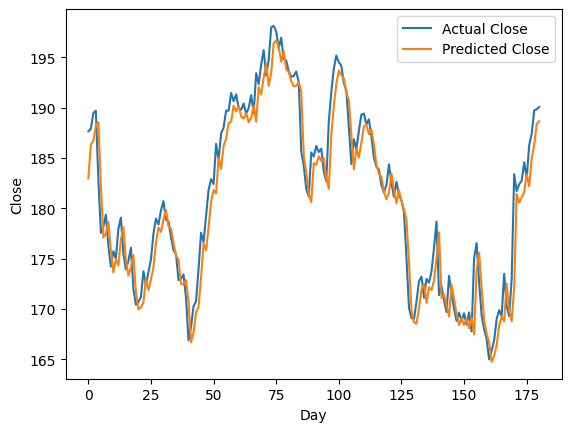

In [19]:
# plot test data
plt.plot(y_test, label="Actual Close")
plt.plot(test_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()


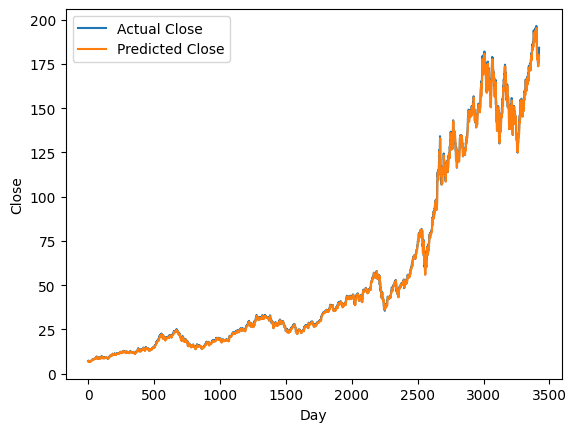

In [20]:
# plot train data
plt.plot(y_train, label="Actual Close")
plt.plot(train_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()
